# 細胞アノテーション練習 2
前回までは古いやり方をしていたため、今回は新しいチュートリアルに沿って行ってみる

https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

In [2]:
import scanpy as sc
import anndata as ad

import pooch

In [ ]:
# 図の解像度やサイズ、背景を設定
sc.settings.set_figure_params(dpi=50, facecolor="white")

In [26]:
# データのダウンロード
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"), # キャッシュフォルダを指定
    base_url="doi:10.6084/m9.figshare.22716739.v1/", #  BMNCの生データ（10x Genomics フォーマットの HDF5） が保存されているDOIリポジトリ
)
EXAMPLE_DATA.load_registry_from_doi()

In [27]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5", # Day 1（1日目）のBMNCデータ
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5", # Day 3（3日目）のBMNCデータ
}
adatas = {}

# pooch を使ってデータをダウンロードし、ローカルにキャッシュ(ダウンロード済みなら キャッシュされたファイルをそのまま利用)
for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path) # 10x Genomics フォーマットを読み込む
    sample_adata.var_names_make_unique() # 遺伝子名の重複がある場合は区別
    adatas[sample_id] = sample_adata # 読み込んだデータを辞書に保存

c:\Users\omuom\miniconda3\envs\env_py312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\omuom\miniconda3\envs\env_py312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\omuom\miniconda3\envs\env_py312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\omuom\miniconda3\envs\env_py312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [28]:
# AnnDataを統合
adata = ad.concat(adatas, label="sample")
adata.var_names_make_unique()  # 変数名（遺伝子名）をユニークにする
adata.obs_names_make_unique()  # 観測データ（細胞ID）をユニークにする
print(adata.obs["sample"].value_counts())

c:\Users\omuom\miniconda3\envs\env_py312\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


In [29]:
adata

AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

## クオリティコントロール

In [30]:
# varには遺伝子の情報（インデックスのみで列はない）
print(adata.var)

Empty DataFrame
Columns: []
Index: [MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3, AL627309.2, AL627309.5, AL627309.4, AP006222.2, AL732372.1, OR4F29, AC114498.1, OR4F16, AL669831.2, LINC01409, FAM87B, LINC01128, LINC00115, FAM41C, AL645608.6, AL645608.2, AL645608.4, LINC02593, SAMD11, NOC2L, KLHL17, PLEKHN1, PERM1, AL645608.7, HES4, ISG15, AL645608.1, AGRN, AL645608.5, AL645608.8, RNF223, C1orf159, AL390719.3, LINC01342, AL390719.2, TTLL10-AS1, TTLL10, TNFRSF18, TNFRSF4, SDF4, B3GALT6, C1QTNF12, AL162741.1, UBE2J2, LINC01786, SCNN1D, ACAP3, PUSL1, INTS11, AL139287.1, CPTP, TAS1R3, DVL1, MXRA8, AURKAIP1, CCNL2, MRPL20-AS1, MRPL20, AL391244.2, ANKRD65, AL391244.1, TMEM88B, LINC01770, VWA1, ATAD3C, ATAD3B, ATAD3A, TMEM240, SSU72, AL645728.1, FNDC10, AL691432.4, AL691432.2, MIB2, MMP23B, CDK11B, FO704657.1, SLC35E2B, CDK11A, SLC35E2A, NADK, GNB1, AL109917.1, CALML6, TMEM52, CFAP74, AL391845.2, GABRD, AL391845.1, PRKCZ, AL590822.2, PRKCZ-AS1, FAAP20, AL590822.1, SKI, ...]

[36601 row

In [31]:
# obsには細胞の情報（インデックスと1列目にサンプル）
print(adata.obs)

                   sample
AAACCCAAGGATGGCT-1   s1d1
AAACCCAAGGCCTAGA-1   s1d1
AAACCCAAGTGAGTGC-1   s1d1
AAACCCACAAGAGGCT-1   s1d1
AAACCCACATCGTGGC-1   s1d1
...                   ...
TTTGTTGAGAGTCTGG-1   s1d3
TTTGTTGCAGACAATA-1   s1d3
TTTGTTGCATGTTACG-1   s1d3
TTTGTTGGTAGTCACT-1   s1d3
TTTGTTGTCGCGCTGA-1   s1d3

[17125 rows x 1 columns]


In [32]:
# ミトコンドリア遺伝子, "MT-" は人間, "Mt-" はねずみ
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [33]:
print(adata.var)

                mt   ribo     hb
MIR1302-2HG  False  False  False
FAM138A      False  False  False
OR4F5        False  False  False
AL627309.1   False  False  False
AL627309.3   False  False  False
...            ...    ...    ...
AC141272.1   False  False  False
AC023491.2   False  False  False
AC007325.1   False  False  False
AC007325.4   False  False  False
AC007325.2   False  False  False

[36601 rows x 3 columns]


In [34]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

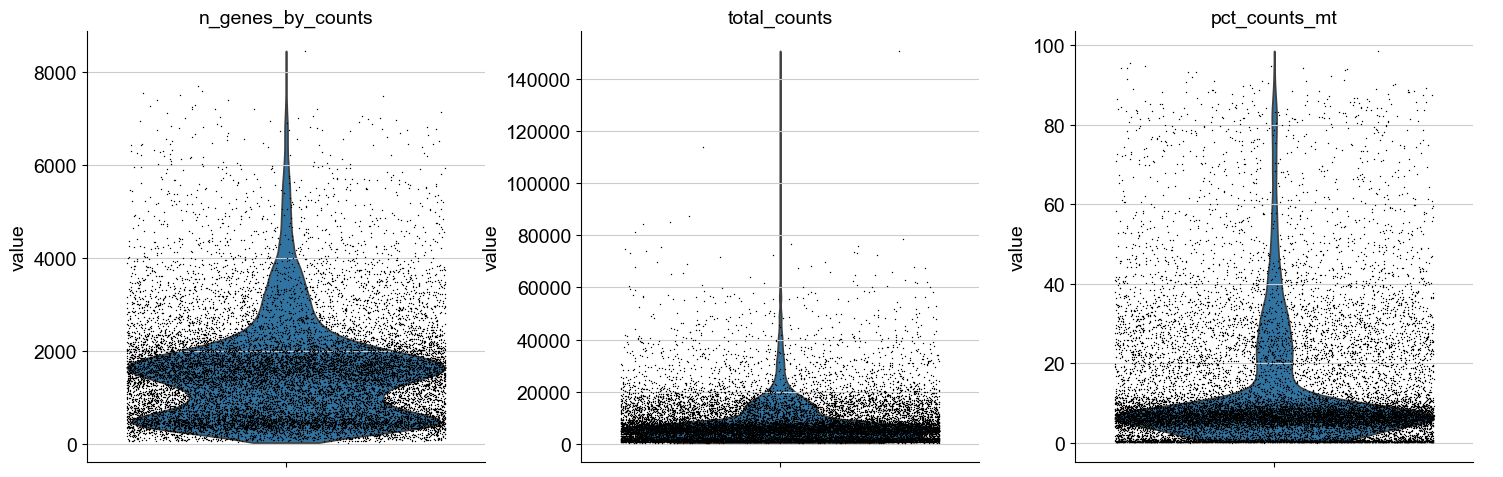

In [38]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

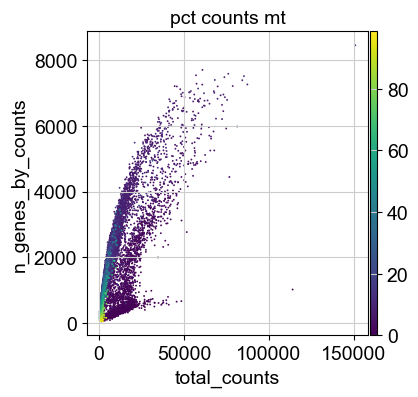

In [39]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
# 最初はおおざっぱにフィルタリングする
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

## ダブレット検出

ダブレットとは、2つまたはそれ以上の細胞が偶然一緒にキャプチャされ、単一の細胞として処理される現象を指します。これはシングルセルデータの解析において大きな問題となります。なぜなら、ダブレットは2つの異なる細胞タイプからの遺伝子発現パターンを混在させることで、細胞タイプの特定や遺伝子発現の解析を誤導する可能性があるからです。
10xgenomicsが公開しているQuality Controlのやり方を見てみると、コミュニティツールを使用したダブレット検出による細胞のフィルタリングについて、「ダブレットやマルチプレットは、解析を混乱させる可能性があります。DoubletFinder、Scrublet、Soloなどのツールがあります。」と述べられて言います。

In [42]:
sc.pp.scrublet(adata, batch_key="sample")

## 正規化

In [43]:
# カウントを保存
adata.layers["counts"] = adata.X.copy()

In [44]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## 選択
データセットの次元を削減し、もっとも情報量のある遺伝子のみを含むようにする。可変性の高い遺伝子に注釈をつける。

In [ ]:
# 可変性の高い遺伝子に注釈をつける（Seurat(デフォルト),Cell Ranger,Seurat v3）
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

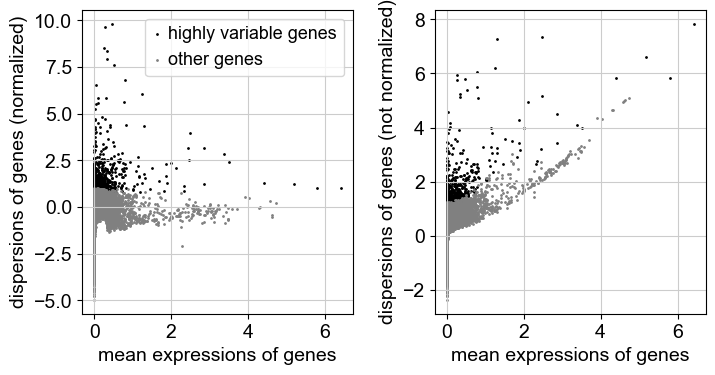

In [ ]:
sc.pl.highly_variable_genes(adata)

## 次元削減

In [47]:
sc.tl.pca(adata)

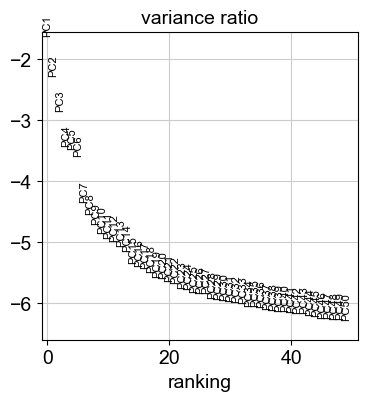

In [48]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

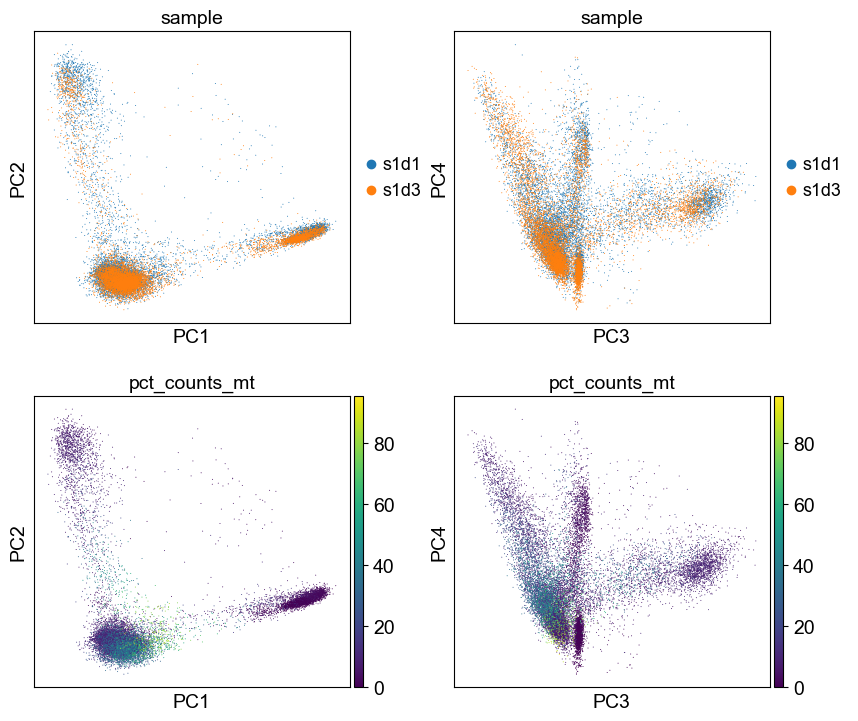

In [49]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## 近傍グラフ

In [50]:
sc.pp.neighbors(adata)

In [51]:
sc.tl.umap(adata)

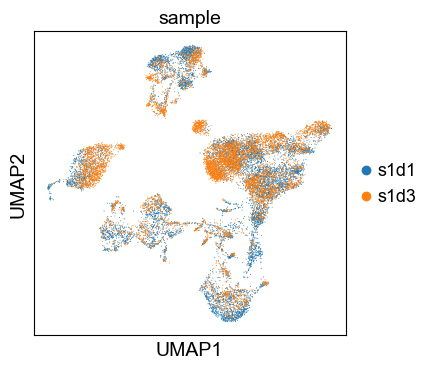

In [52]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

## クラスタリング

In [ ]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)